### Import Packages

In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import randint
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV )
from sklearn.metrics import r2_score

### Global Variables

In [35]:
AUTOMODE = True
imputer = SimpleImputer(strategy='mean')   # deal with missing area

train_file_path = '../data_processing/Unfiltered-Data/Train/train-data-5-year.csv'
test_file_path = '../data_processing/Unfiltered-Data/Test/test-data-5-year.csv'
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

X_training, X_validation, Y_training, Y_validation = [], [], [], []

### Get Training and Validation Dataset
- training: train model
- validation: early stopping
- testing: evaluate model

In [36]:
def DataPreprocessing(train_df, test_df):
    # Prepocess data frame, convert all elements to int/float type, deal with NaN value in area column.
    train_df = train_df.apply(pd.to_numeric, errors='coerce')
    train_df['area'] = imputer.fit_transform(train_df[['area']])

    # Split data frame into feature set and label set, then seperate both into training and validation dataset.
    features = train_df.drop('price', axis='columns')
    label = train_df['price']

    X_training, X_validation, Y_training, Y_validation = train_test_split(features, label, test_size=0.3, random_state=3)
    X_testing = test_df.drop('price', axis='columns')
    Y_testing = test_df['price']

    # split training dataset into training and validation dataset, for early stopping
    return X_training, X_validation, Y_training, Y_validation, X_testing, Y_testing

X_training, X_validation, Y_training, Y_validation, X_testing, Y_testing = DataPreprocessing(train_df, test_df)
print('[OK] DataPreprocessing')
print(f'{type(X_training)} {X_training.shape}')
print(f'{type(Y_training)} {Y_training.shape}')
print(f'{type(X_validation)} {X_validation.shape}')
print(f'{type(Y_validation)} {Y_validation.shape}')
print(f'{type(X_testing)} {X_testing.shape}')
print(f'{type(Y_testing)} {Y_testing.shape}')

[OK] DataPreprocessing
<class 'pandas.core.frame.DataFrame'> (17873, 24)
<class 'pandas.core.series.Series'> (17873,)
<class 'pandas.core.frame.DataFrame'> (7660, 24)
<class 'pandas.core.series.Series'> (7660,)
<class 'pandas.core.frame.DataFrame'> (2837, 24)
<class 'pandas.core.series.Series'> (2837,)


In [37]:
# parameters
num_iterations = 50

# 5 years
rf_parameters = {
    'n_estimators': 200,
    'criterion': 'friedman_mse',
    'max_depth': 18,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'random_state': 165,
    'n_jobs': -1
}

### Randomized Cross Validation

In [38]:
def AutoTuningRandomized(X_training, Y_training):
    param = {
        'n_estimators': randint(100, 200),
        'max_depth': randint(10, 20),
        'min_samples_split': randint(2, 5),
        'min_samples_leaf': randint(1, 4),
        'random_state': randint(100, 200),
    }

    # automatically search for best parameters and the corresponding score
    result = RandomizedSearchCV (
        RandomForestRegressor(),
        param_distributions=param,
        scoring='r2',
        verbose=4,
        cv=3,
        n_iter=3
    )

    result.fit(X_training, Y_training)
    best_param = result.best_params_
    best_score = result.best_score_
    print(f'Best param in rCV: {best_param}')
    print(f'Best score in rCV: {round(best_score * 100, 3)}')

    return best_param

params_randomized = AutoTuningRandomized(X_training, Y_training)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END max_depth=16, min_samples_leaf=2, min_samples_split=2, n_estimators=171, random_state=153;, score=0.866 total time=   4.9s
[CV 2/3] END max_depth=16, min_samples_leaf=2, min_samples_split=2, n_estimators=171, random_state=153;, score=0.869 total time=   4.8s
[CV 3/3] END max_depth=16, min_samples_leaf=2, min_samples_split=2, n_estimators=171, random_state=153;, score=0.875 total time=   4.8s
[CV 1/3] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=155, random_state=165;, score=0.861 total time=   3.8s
[CV 2/3] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=155, random_state=165;, score=0.864 total time=   3.8s
[CV 3/3] END max_depth=12, min_samples_leaf=2, min_samples_split=4, n_estimators=155, random_state=165;, score=0.871 total time=   3.9s
[CV 1/3] END max_depth=19, min_samples_leaf=1, min_samples_split=4, n_estimators=142, random_state=128;, score=0.868 total ti

### Grid Cross Validation

In [39]:
def AutoTuningGrid(X_training, Y_training):

    params = {
        'n_estimators': list(range(100, 201, 5)),
        'max_depth': list(range(10, 21, 2)),
        'min_samples_split': list(range(2, 5, 1)),
        'min_samples_leaf': list(range(1, 4, 1)),
        'random_state': list(range(100, 201, 5))
    }

    best_param = {
        'n_estimators': -1,
        'max_depth': -1,
        'min_samples_split': -1,
        'min_samples_leaf': -1,
        'random_state': -1
    }

    for name, value in params.items():
        param_single = {name: value}

        result = GridSearchCV (
            RandomForestRegressor(),
            param_grid=param_single,
            scoring='r2',
            verbose=4,
            cv=3
        )

        result.fit(X_training, Y_training)
        best_param[name] = result.best_params_[name]
        best_score = result.best_score_
        print(f"Best {name}: {best_param}")
        print(f'Best {name} score: {round(best_score * 100, 3)}')

    return best_param

params_grid = AutoTuningGrid(X_training, Y_training)

Fitting 3 folds for each of 21 candidates, totalling 63 fits
[CV 1/3] END ..................n_estimators=100;, score=0.869 total time=   3.5s
[CV 2/3] END ..................n_estimators=100;, score=0.871 total time=   3.5s
[CV 3/3] END ..................n_estimators=100;, score=0.875 total time=   3.5s
[CV 1/3] END ..................n_estimators=105;, score=0.867 total time=   3.6s
[CV 2/3] END ..................n_estimators=105;, score=0.870 total time=   3.7s
[CV 3/3] END ..................n_estimators=105;, score=0.876 total time=   3.6s
[CV 1/3] END ..................n_estimators=110;, score=0.868 total time=   3.8s
[CV 2/3] END ..................n_estimators=110;, score=0.870 total time=   3.8s
[CV 3/3] END ..................n_estimators=110;, score=0.876 total time=   3.8s
[CV 1/3] END ..................n_estimators=115;, score=0.869 total time=   4.0s
[CV 2/3] END ..................n_estimators=115;, score=0.870 total time=   4.0s
[CV 3/3] END ..................n_estimators=115;

### Random Forest

In [40]:

def RandomForest(param, autoMode=False):


    def RandomForestRegressor_aux(param):
        regressor_auto = RandomForestRegressor(
            n_estimators=param['n_estimators'],
            criterion='friedman_mse',
            max_depth=param['max_depth'],
            min_samples_split=param['min_samples_split'],
            min_samples_leaf=param['min_samples_leaf'],
            max_features='sqrt',
            random_state=param['random_state'],
            n_jobs=-1
        )
        return regressor_auto
    
    
    print('Start building regressor ...')
    if autoMode is True:
        regressor = RandomForestRegressor_aux(param)
    else:   # manually
        regressor = RandomForestRegressor(
            n_estimators=131,
            criterion='friedman_mse',
            max_depth=15,
            min_samples_split=2,
            min_samples_leaf=3,
            max_features='sqrt',
            random_state=156,
            n_jobs=-1
        )
    print('[OK] Build Regressor')

    regressor.fit(X_training, Y_training)

    return regressor

regressor = RandomForest(params_grid, autoMode=AUTOMODE)
print('[OK] RandomForest')

Start building regressor ...
[OK] Build Regressor
[OK] RandomForest


### Make Predictions

In [46]:
def MakePredictions(testing_dataset, regressor, validation_dataset=None):
    predictions = regressor.predict(testing_dataset)

    if validation_dataset is not None:
        r2 = r2_score(validation_dataset, predictions)
        # output scores
        print(f'R2 score: {round(r2, 5)}')

    return predictions

print('Training Dataset')
Y_predictions_training = MakePredictions(X_training, regressor, Y_training)

Training Dataset
R2 score: 0.95764


In [47]:
print('Validation Dataset')
Y_predictions_validation = MakePredictions(X_validation, regressor, Y_validation)
print()
print('Testing Dataset')
Y_predictions_testing = MakePredictions(X_testing, regressor, Y_testing)

Validation Dataset
R2 score: 0.87179

Testing Dataset
R2 score: 0.87967


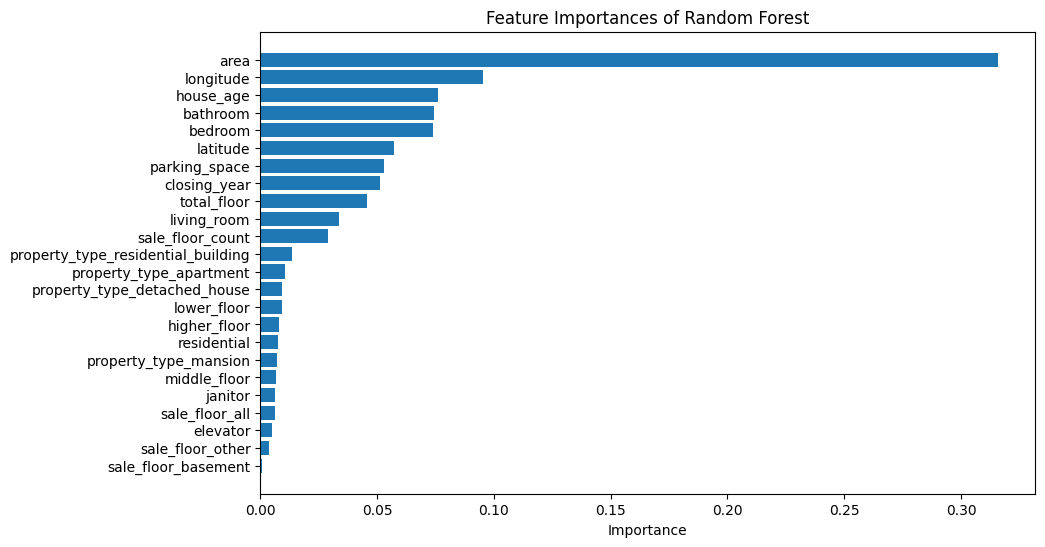

In [49]:
def FeatureImportances(df, regressor):
    feature_names = df.columns[:-1]
    feature_importances = regressor.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importances of Random Forest')
    plt.show()

FeatureImportances(train_df, regressor)